# Callibration and Preprocessing

**Begginer's Notes**: 
- shift+tab directly after a function (before the paranthesis) to get a pop up window with the documentation
- typing the function name followed by a question mark will output an answer box with the functions document string
- to see the source code of a function navigate to its location in your local py4DSTEM directory 
    - for example: if you'd like to see the soyrce code for py4DSTEM.process.utils.get_COM navigate to your py4DSTEM directory, open the folder, navigate to process, then utils, and find the get_COM function in the utils folder
    - *The source code will tell you exactly what a function does*

## 1. Global Imports

In [88]:
import py4DSTEM

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle, Circle, Arc
from scipy.ndimage.filters import gaussian_filter
from time import time

from py4DSTEM.process.braggdiskdetection import get_average_probe_from_ROI, get_probe_kernel_subtrgaussian
from py4DSTEM.process.utils import get_CoM
from py4DSTEM.file.datastructure import DiffractionSlice, RealSlice, PointList, PointListArray
from py4DSTEM.file.io import read, save, append, FileBrowser
from py4DSTEM.process.braggdiskdetection import find_Bragg_disks_selected, find_Bragg_disks, find_Bragg_disks_single_DP, find_Bragg_disks_single_DP_FK
from py4DSTEM.process.braggdiskdetection import get_bragg_vector_map, threshold_Braggpeaks

In [89]:
# Load data -- This might take a while 
fp = '/Users/jenniferdonohue/Documents/Research/Silicon/alpha-Si-counted-bin8x_cropped.h5' # set the file path
dc = py4DSTEM.file.io.read(fp) # datacube import

/Users/jenniferdonohue/Documents/Research/Silicon/alpha-Si-counted-bin8x_cropped.h5 is a py4DSTEM file, v0.6. Reading...


## 2. Preliminary Visualization of Data

To start we'll do some preliminary visualization. We'll create an average shift uncorrected diffraction pattern, a bright field image, and a dark field image. To do this we'll create some virtual apertures and integrate the intensity of the diffraction patterns in those aperture rings. Then we'll save these to a file to be used later.

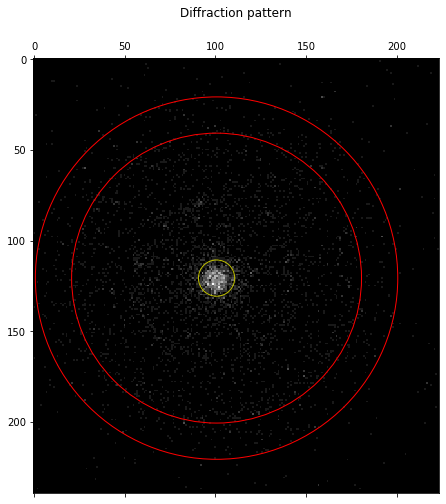

In [90]:
## Select detector positions while looking at a single diffraction pattern

rx,ry = np.random.randint(0,dc.R_Nx),np.random.randint(0,dc.R_Ny)                              # Scan position

BF_detector_max = 10                        # Bright Field detector in pixels from center 
ADF_detector_min, ADF_detector_max = 80,100  #  Dark Field detector in pixels from center

DP = dc.data[rx,ry,:,:]
x0,y0 = py4DSTEM.process.utils.get_CoM(dc.data[rx,ry,:,:])

# Plot images
fig, ax = plt.subplots(figsize=[8,8])
ax.matshow(DP)
ax.set_title('Diffraction pattern', pad = 20)

circle_ADF_inner = Circle((y0,x0),radius=ADF_detector_max, fill=False, edgecolor='r', linestyle="-")
circle_ADF_outer = Circle((y0,x0),radius=ADF_detector_min, fill=False, edgecolor='r', linestyle="-")
circle_BF_outer = Circle((y0,x0),radius=BF_detector_max, fill=False, edgecolor='y', linestyle="-")
ax.add_patch(circle_ADF_inner)
ax.add_patch(circle_ADF_outer)
ax.add_patch(circle_BF_outer)

plt.show()

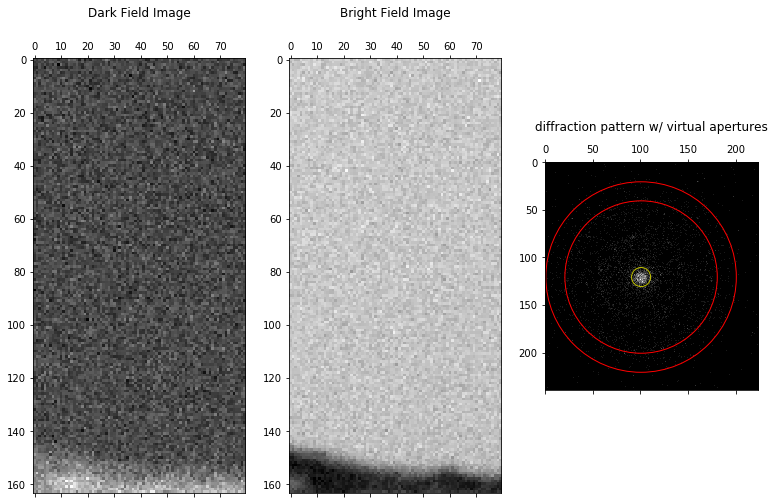

In [91]:
## Create Bright Field and Dark Field Image using Virtual Aperture 

# Annular Images  
ADF = dc.get_virtual_image_annular_integrate((slice(int(x0)-ADF_detector_max,int(x0)+ADF_detector_max)),
                                             (slice(int(y0)-ADF_detector_max,int(y0)+ADF_detector_max)),
                                                    ADF_detector_max/ADF_detector_min)[0]
BF = dc.get_virtual_image_circ_integrate((slice(int(x0)-BF_detector_max,int(x0)+BF_detector_max)),
                                             (slice(int(y0)-BF_detector_max,int(y0)+BF_detector_max)))[0]



# Plot images
fig, ax = plt.subplots(1,3,figsize=[13,8])
ax[0].matshow(ADF)
ax[0].set_title('Dark Field Image', pad = 20)

ax[1].matshow(BF)
ax[1].set_title('Bright Field Image', pad =20)

power = 0.1 #scale the DP intensity by a power to better visualize it

ax[2].matshow(DP)
circle_ADF_inner = Circle((y0,x0),radius=ADF_detector_max, fill=False, edgecolor='r', linestyle="-")
circle_ADF_outer = Circle((y0,x0),radius=ADF_detector_min, fill=False, edgecolor='r', linestyle="-")
circle_BF_outer = Circle((y0,x0),radius=BF_detector_max, fill=False, edgecolor='y', linestyle="-")
ax[2].add_patch(circle_ADF_inner)
ax[2].add_patch(circle_ADF_outer)
ax[2].add_patch(circle_BF_outer)
ax[2].set_title('diffraction pattern w/ virtual apertures', pad=20)

plt.show()

In [92]:
# Save Images as Realslices 
ADF_data= np.empty((dc.R_Nx,dc.R_Ny,1))
ADF_data[:,:,0] = ADF
BF_data= np.empty((dc.R_Nx,dc.R_Ny,1))
BF_data[:,:,0] = BF

virtual_ADF_image = py4DSTEM.file.datastructure.RealSlice(ADF_data, name='virtual_ADF_image')
virtual_BF_image = py4DSTEM.file.datastructure.RealSlice(BF_data, name='virtual_BF_image')

## 3. Creating a Vacuum Probe

A vacuum probe is used as a template to match/find the disk positions. Here we'll use it to find our center disks.  py4DSTEM supports 3 methods of vacuum probe extraction - from a vacuum scan, from a vacuum region, and synthetically.  Here, we'll get a vacuum probe from a vacuum region of our scan.

** this is the spot where I want to redirect to the other notebooks** 

### Select Region of Interest

We'll select a region of interest (ROI) in our sample from which to extract a vacuum probe. This should be representative if the sample which you are trying to find bragg peaks in. get_average_probe_from_ROI aligns and averages all diffraction patterns within a specified ROI of a datacube to create an average vacuum probe.

For example if you have an entire nanoparticle in your field of view, you will want to place your ROI on the nanoparticle, not over the support material or edge of the scan. 

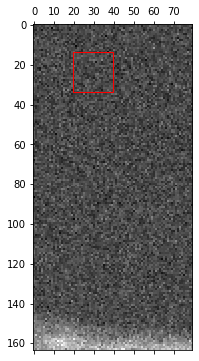

In [93]:
# Select a Region of Interest using max and min x and y values 

xmin,xmax=14, 34
ymin,ymax=20,40

ROI = np.zeros_like(dc.data[:,:,0,0],dtype=bool)
ROI[xmin:xmax,ymin:ymax] = True

# Display
roi_rect = Rectangle(xy=(ymin-0.5,xmin-0.5),width=ymax-ymin,height=xmax-xmin,fill=False,color='r')

fig,ax=plt.subplots(figsize=(6,6))
ax.matshow(ADF,cmap='gray')
ax.add_patch(roi_rect)
plt.show()

Now we will set the parameters we need for the get_average_probe_from_ROI function. We want to create an image of just the center probe. To do this, we'll create a mask that zeros out all the pixels that we decide are not part of the center probe. To create this mask we will use several parameter which are user defined. 

1. **mask_threshold**: this allows us to choose all pixel values > [mask_threshold*(the max intensity in the DP)] as true and all other pixels as zeros
2. **mask_opening**: if an opening (or a set of true value pixels) consists of less than this number of pixels, we're going to close it 
3. **mask_expansion**: to make sure we've encompassed the whole probe, we're going to expand the edges of the 'openings' in our mask by this many pixels
4. **verbose**: if verbose is an input, this tells us that the function has some sort of progress output or intermediate output; set 'True' to view the progress or intermediate output or 'False' to suppress these outputs

In [94]:
# Get average, shift-corrected probe from ROI
# This step can take a little time, as shift correction requires taking FFTs

mask_threshold = 0.2
mask_expansion = 12
mask_opening = 3 
verbose = False

probe = get_average_probe_from_ROI(dc, ROI=ROI, 
                                       mask_threshold=mask_threshold, 
                                       mask_expansion=mask_expansion,
                                       mask_opening=mask_opening,
                                       verbose=verbose)

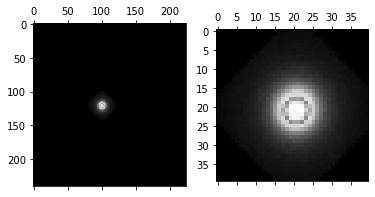

In [95]:
# Show average probe
# The probe has an apparent dark ring around it, this is an artifact of the electron counting performed on this data set 

rad = 20                              # for zoomed-in display 
xCoM_init,yCoM_init = get_CoM(probe) # Getting the center of mass of the probe

fig,(ax1,ax2)=plt.subplots(1,2)
ax1.matshow(probe,cmap='gray')
ax2.matshow(probe[int(xCoM_init)-rad:int(xCoM_init)+rad,int(yCoM_init)-rad:int(yCoM_init)+rad])
plt.show()

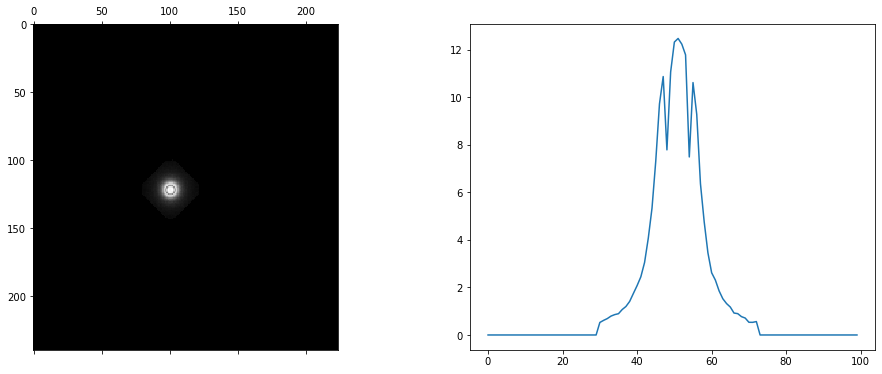

In [96]:
# Display probe_kernel, with line profile

rad=30
lineprofile_length= 50

line_profile = np.sum(probe[int(xCoM_init)-lineprofile_length:int(xCoM_init)+lineprofile_length,int(yCoM_init)-1:int(yCoM_init)+1],axis=(1))

fig,(ax1,ax2)=plt.subplots(1,2,figsize=(16,6))
ax1.matshow(probe)
ax2.plot(np.arange(len(line_profile)),line_profile)
plt.show()

### Create vacuum probe kernel

Here, we turn the vacuum probe into a convolution kernel for the later template-matching step. This probe will be the template we use to detect bragg disks in the diffraction patterns. To make this template more sensitive to edges, here there is added small troughs on either side of the probe. These troughs will penalized 

**This needs more annotation**

In [97]:
sigma_probe_scale=3

probe_kernel = get_probe_kernel_subtrgaussian(probe, sigma_probe_scale=sigma_probe_scale)

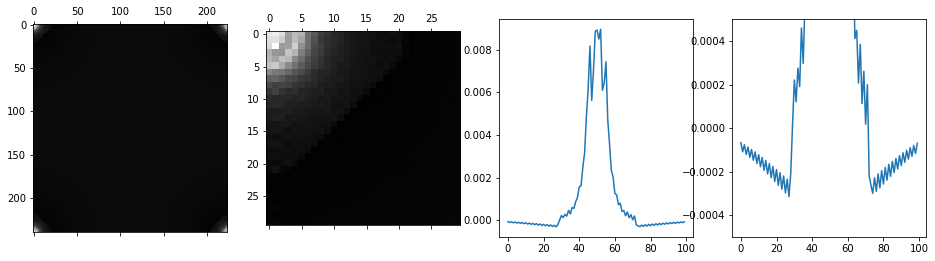

In [98]:
# Display probe_kernel, with line profile

rad=30
lineprofile_length= 50
lineprofile_width=2

xCom,yCoM = np.unravel_index(np.argmax(probe_kernel),(dc.Q_Nx,dc.Q_Ny))
line_profile_left = np.sum(probe_kernel[-lineprofile_length:,:lineprofile_width],axis=(1))
line_profile_right = np.sum(probe_kernel[:lineprofile_length,:lineprofile_width],axis=(1))
line_profile = np.concatenate([line_profile_left,line_profile_right])

fig,(ax1,ax2,ax3,ax4)=plt.subplots(1,4,figsize=(16,4))
ax1.matshow(probe_kernel)
ax2.matshow(probe_kernel[:rad,:rad])
ax3.plot(np.arange(len(line_profile)),line_profile)
ax4.plot(np.arange(len(line_profile)),line_profile)
ax4.set_ylim(-0.0005,0.0005)
plt.show()

## 4. Finding Center Disk Location 

### Test parameters on a few diffraction patterns

In the cell below, we detect the Bragg disk positions in just a few diffraction patterns.  This is because the full calculation can be quite slow, so selecting just a few DPs allows us to quickly test parameters to figure out how best to locate the peaks.  It is worth taking your time at this step!

First, choose 3 scan positions to test.  I typically choose a very clean diffraction pattern, a very noisy one, and something in between.

#### **Understanding and Setting the User Input Parameters**
1. **CorrPower**: the cross correlation power. A value of 1 corresponds to a cross correaltion, and 0 corresponds to a phase correlation, with intermediate values giving various hybrids.

2. **sigma**: standard deviation for guassian smoothing applied to cross-correlation

3. **edgeBoundary**: distance in pixels from the diffraction pattern edge, defines how much of the pattern will be used in the correlation 

4. **maxNumPeaks**: maximum number of peaks that will be identified (10 is usually good, but you should view a single DP to get an idea for this setting)

5. **minPeakSpacing**: the minimum number of pixels between peaks (guards against identifying a single peak as multiple)

6. **minRelativeIntensity**: scaling factor used to determine minimum intensity that can be considered a peak - if (minRelativeIntensity*[max intensity of the DP]) < Peak Intensity this will not be considered a peak -

7. **subpixel**: subpixel fitting settings - 'poly': polynomial interpolation of correlogram peaks (fairly fast but not very accurate)'multicorr': uses the multicorr algorithm with DFT upsampling

We are only interested in the center disk, so to speed up the calculation we'll set the edge boundary very large as to only detect disks near the centers of the patterns

Analyzed 3 diffraction patterns in 0h 0m 0s


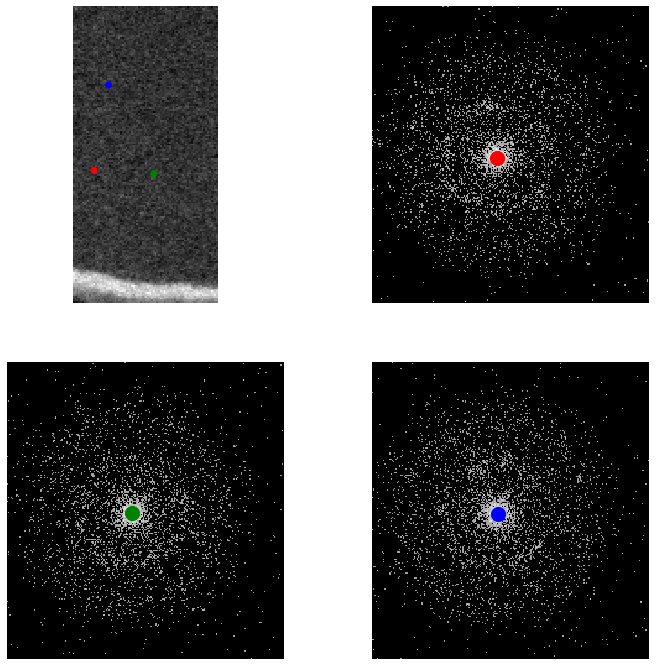

In [99]:
######## Parameters ########

# Select scan positions
Rxs = np.random.randint(0,dc.R_Nx, size =3)
Rys = np.random.randint(0,dc.R_Ny, size =3)  

# Peak detection parameters
corrPower = 1
sigma = 2
edgeBoundary = 70 
maxNumPeaks = 1
minPeakSpacing = 2
minRelativeIntensity = 0.03
subpixel = 'poly'


# Display parameters
power = 0.2    # To increase the contrast in the pattern we raise it to a power between 0 and 1
size_scale_factor = 200       # Set to zero to make all points the same size

############################

# Find peaks
peaks = find_Bragg_disks_selected(dc, probe_kernel, Rxs, Rys,
                                  corrPower=corrPower,
                                  sigma=sigma,
                                  edgeBoundary=edgeBoundary,
                                  minRelativeIntensity=minRelativeIntensity,
                                  minPeakSpacing=minPeakSpacing,
                                  maxNumPeaks=maxNumPeaks,
                                  subpixel=subpixel)

# Show
fig,((ax11,ax12),(ax21,ax22))=plt.subplots(2,2,figsize=(12,12))
ax11.matshow(np.average(dc.data,axis=(2,3)))
ax11.scatter(Rys,Rxs,color=('r','g','b'))
ax12.matshow(dc.data[Rxs[0],Rys[0],:,:]**power)
ax21.matshow(dc.data[Rxs[1],Rys[1],:,:]**power)
ax22.matshow(dc.data[Rxs[2],Rys[2],:,:]**power)

if size_scale_factor == 0:
    ax12.scatter(peaks[0].data['qy'],peaks[0].data['qx'],color='r')
    ax21.scatter(peaks[1].data['qy'],peaks[1].data['qx'],color='g')
    ax22.scatter(peaks[2].data['qy'],peaks[2].data['qx'],color='b')
else:
    ax12.scatter(peaks[0].data['qy'],peaks[0].data['qx'],color='r',s=size_scale_factor*peaks[0].data['intensity']/np.max(peaks[0].data['intensity']))
    ax21.scatter(peaks[1].data['qy'],peaks[1].data['qx'],color='g',s=size_scale_factor*peaks[1].data['intensity']/np.max(peaks[1].data['intensity']))
    ax22.scatter(peaks[2].data['qy'],peaks[2].data['qx'],color='b',s=size_scale_factor*peaks[2].data['intensity']/np.max(peaks[2].data['intensity']))

ax11.axis('off')
ax12.axis('off')
ax21.axis('off')
ax22.axis('off')
plt.show()

### Find Bragg disks in all diffraction patterns
 Perform disk detection on entire data set. Since we're only interested in the central disk, we'll use the center detected above to crop down the area in which we are detecting disks in our patterns and increase the speed of detection. 

In [100]:
# Find Center Disks in Entire Data Set 
braggpeaks = find_Bragg_disks(dc, probe_kernel,
                              corrPower=corrPower,
                              sigma=sigma,
                              edgeBoundary=edgeBoundary,
                              minRelativeIntensity=minRelativeIntensity,
                              minPeakSpacing=minPeakSpacing,
                              maxNumPeaks=maxNumPeaks,
                              subpixel=subpixel,
                              verbose=verbose)
braggpeaks.name = 'braggpeaks'

Analyzed 13120 diffraction patterns in 0h 1m 31s


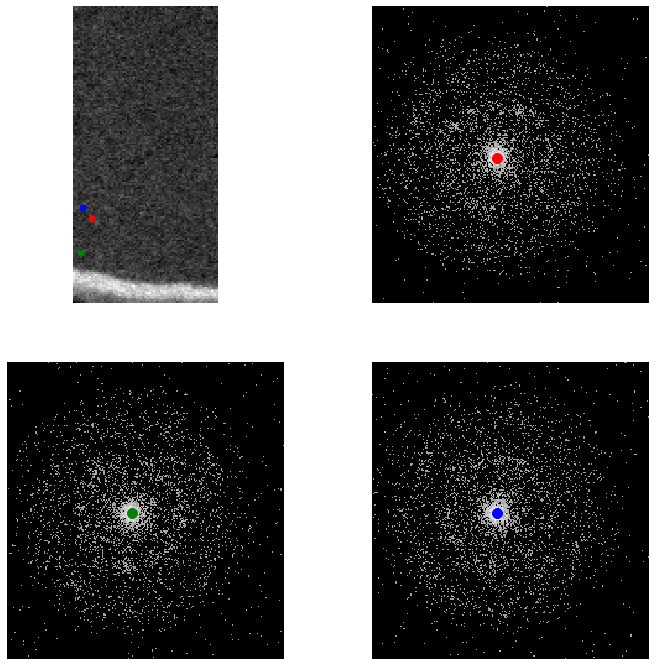

In [101]:
# Show results for a few DPs

xs = np.random.randint(0,dc.R_Nx, size =3)
ys = np.random.randint(0,dc.R_Ny, size =3)  

power=0.2

fig,((ax11,ax12),(ax21,ax22))=plt.subplots(2,2,figsize=(12,12))

ax11.matshow(np.average(dc.data,axis=(2,3)))
ax11.scatter(ys,xs,color=('r','g','b'))

ax12.matshow(dc.data[xs[0],ys[0],:,:]**power)
ax21.matshow(dc.data[xs[1],ys[1],:,:]**power)
ax22.matshow(dc.data[xs[2],ys[2],:,:]**power)

peaks0 = braggpeaks.get_pointlist(xs[0],ys[0])
peaks1 = braggpeaks.get_pointlist(xs[1],ys[1])
peaks2 = braggpeaks.get_pointlist(xs[2],ys[2])

ax12.scatter(peaks0.data['qy'],peaks0.data['qx'],color='r',s=100*peaks0.data['intensity']/np.max(peaks0.data['intensity']))
ax21.scatter(peaks1.data['qy'],peaks1.data['qx'],color='g',s=100*peaks1.data['intensity']/np.max(peaks1.data['intensity']))
ax22.scatter(peaks2.data['qy'],peaks2.data['qx'],color='b',s=100*peaks2.data['intensity']/np.max(peaks2.data['intensity']))

ax11.axis('off')
ax12.axis('off')
ax21.axis('off')
ax22.axis('off')
plt.show()

## 5. Selecting a Region to Perform RDF
RDF analysis is good at revealing local variation in short or medium range order. Here, we will select a ROI and create an average diffraction pattern from that area which we will then perform RDF on. 

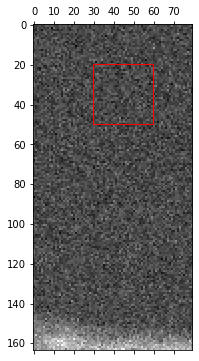

In [102]:
# Select a Region of Interest using max and min x and y values 

xmin,xmax=20,50
ymin,ymax=30,60

ROI = np.zeros_like(dc.data[:,:,0,0],dtype=bool)
ROI[xmin:xmax,ymin:ymax] = True

# Display
roi_rect = Rectangle(xy=(ymin-0.5,xmin-0.5),width=ymax-ymin,height=xmax-xmin,fill=False,color='r')

fig,ax=plt.subplots(figsize=(6,6))
ax.matshow(ADF,cmap='gray')
ax.add_patch(roi_rect)
plt.show()

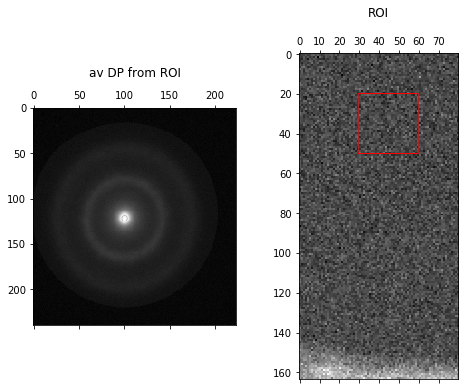

In [103]:
# Create Average DP
xinit, yinit = int(braggpeaks.get_pointlist(xmin,ymin).data['qx'][0]), int(braggpeaks.get_pointlist(xmin,ymin).data['qy'][0])

DP_new = np.zeros_like(dc.data[:,:,:,:],dtype=float)
avDP_ROI = np.zeros_like(dc.data[0,0,:,:],dtype=float)
for Rx in np.arange(xmin, xmax, 1):
    for Ry in np.arange(ymin, ymax, 1):
        x0, y0 = int(braggpeaks.get_pointlist(Rx,Ry).data['qx'][0]), int(braggpeaks.get_pointlist(Rx,Ry).data['qy'][0])
        DP = dc.data[Rx,Ry,:,:]
        DP_new[Rx,Ry] = np.roll(np.roll(DP,xinit-x0,axis=0),yinit-y0,axis=1)
        avDP_ROI += DP_new[Rx,Ry]

avDP_ROI = avDP_ROI/((xmax-xmin)*(ymax-ymin))

# plot average DP
fig, ax = plt.subplots(1,2, figsize=[8,6])
power = 0.5
ax[0].matshow(avDP_ROI**power)
ax[0].set_title('av DP from ROI', pad =20)

ax[1].matshow(ADF)
roi_rect = Rectangle(xy=(ymin-0.5,xmin-0.5),width=ymax-ymin,height=xmax-xmin,fill=False,color='r')
ax[1].add_patch(roi_rect)
ax[1].set_title('ROI', pad =20)

plt.show()

In [104]:
# Save the average Diffraction Data from ROI as Diffraction Slice 
DP_ROI_data= np.empty((dc.Q_Nx,dc.Q_Ny,1))
DP_ROI_data[:,:,0] = avDP_ROI
avg_DP_ROI = py4DSTEM.file.datastructure.DiffractionSlice(DP_ROI_data, name='avg_DP_ROI')

# Save ROI Coordinates and Center Location
coordinates = [('xmin', 'float64'), ('xmax', 'float64'), ('ymin', 'float64'), ('ymax', 'float64'), 
               ('qx_center', 'float64'), ('qy_center','float64')]
ROI = PointList(coordinates = coordinates, name = 'ROI')
ROI_selected = np.asarray([xmin, xmax, ymin, ymax, xinit, yinit])
ROI_selected = ROI_selected.astype(float)
ROI.add_point(ROI_selected)


## 6. Pixel Size Callibration 

At the bottom of our scan there is a crystalline region. We will use the crystalline diffraction patterns as a standard to callibrate our data. First let's take a look at these patterns.

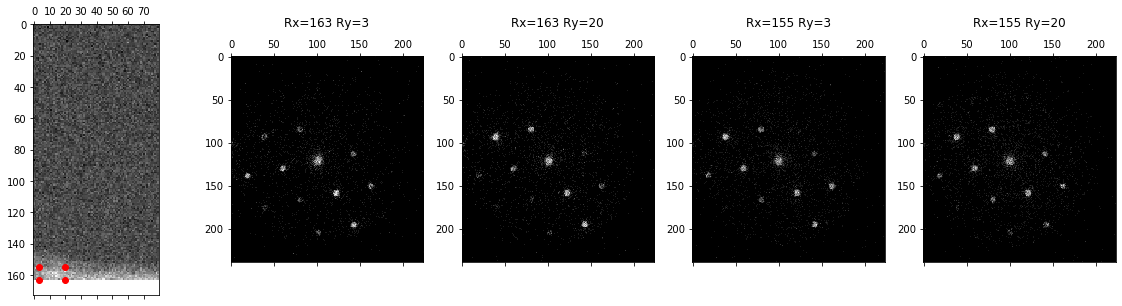

In [105]:
# Let's take a look at a few diffraction patterns in the crystalline region
Rx, Ry = [163,163,155,155], [3,20,3,20]
fig, ax = plt.subplots(1,len(Rx)+1, figsize = [5*len(Rx),5])
ax[0].matshow(ADF)
ax[0].scatter(Ry,Rx, color ='r')
for r in range(len(Rx)):
    ax[r+1].matshow(dc.data[Rx[r], Ry[r],:,:])
    ax[r+1].set_title('Rx='+str(Rx[r])+' Ry='+str(Ry[r]), pad = 20)

plt.show()

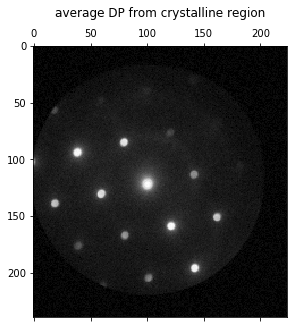

In [106]:
# Now let's make an average diffraction pattern from this region 
# We'll shift all the patterns to the center point of the top left corner 
xmin, ymin, xmax, ymax = 155, 3, 163, 20
xinit, yinit = int(braggpeaks.get_pointlist(xmin,ymin).data['qx'][0]), int(braggpeaks.get_pointlist(xmin,ymin).data['qy'][0])

DP_crystalline = np.zeros_like(dc.data[:,:,:,:],dtype=float)
avDP_crystalline = np.zeros_like(dc.data[0,0,:,:],dtype=float)
for Rx in np.arange(xmin, xmax, 1):
    for Ry in np.arange(ymin, ymax, 1):
        x0, y0 = int(braggpeaks.get_pointlist(Rx,Ry).data['qx'][0]), int(braggpeaks.get_pointlist(Rx,Ry).data['qy'][0])
        DP = dc.data[Rx,Ry,:,:]
        DP_crystalline[Rx,Ry] = np.roll(np.roll(DP,xinit-x0,axis=0),yinit-y0,axis=1)
        avDP_crystalline += DP_crystalline[Rx,Ry]

avDP_crystalline = avDP_crystalline/((xmax-xmin)*(ymax-ymin))

# Let's take a look at our average diffraction pattern
power = 0.5
fig, ax = plt.subplots(1,1, figsize= [5,5])
ax.matshow(avDP_crystalline**power)
ax.set_title('average DP from crystalline region', pad = 15)

plt.show()

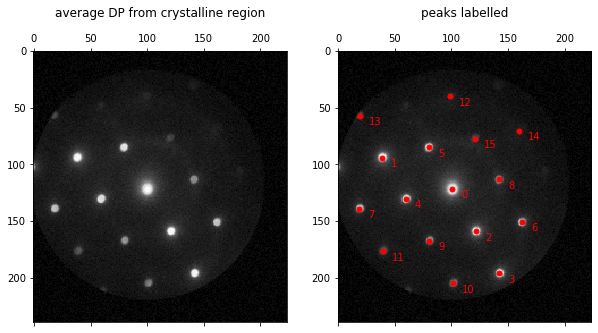

In [107]:
# Next we'll locate the bragg peaks in our average crystalline DP so we can index them 
# We'll define some new parameters
corrPower = 1 # We'll use cross correlation 
sigma = 2
edgeBoundary = 10
maxNumPeaks = 20
minPeakSpacing = 2
minRelativeIntensity = 0.005
subpixel = 'poly'


crystal_peaks = find_Bragg_disks_single_DP(avDP_crystalline, probe_kernel,
                                  corrPower=corrPower,
                                  sigma=sigma,
                                  edgeBoundary=edgeBoundary,
                                  minRelativeIntensity=minRelativeIntensity,
                                  minPeakSpacing=minPeakSpacing,
                                  maxNumPeaks=maxNumPeaks,
                                  subpixel=subpixel)


# Let's take a look at our peaks and average diffraction pattern
power = 0.5
labels = np.arange(0,crystal_peaks.data['qy'].shape[0])
fig, ax = plt.subplots(1,2, figsize= [10,5])
ax[0].matshow(avDP_crystalline**power)
ax[0].set_title('average DP from crystalline region', pad = 20)
ax[1].matshow(avDP_crystalline**power)
ax[1].set_title('peaks labelled', pad = 20)
ax[1].scatter(crystal_peaks.data['qy'], crystal_peaks.data['qx'], color = 'r', s=25) 
for i in range(labels.shape[0]):
    ax[1].annotate(str(labels[i]), (crystal_peaks.data['qy'][i]+8, crystal_peaks.data['qx'][i]+8), color ='r')

plt.show()

angle= 55.535  ratio= 0.859  flipped ratio= 1.163


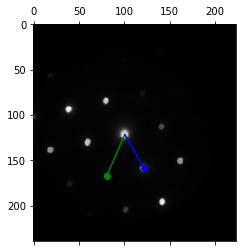

In [108]:
# Distances from center peak
qr = np.sqrt((crystal_peaks.data['qx'][1::]-crystal_peaks.data['qx'][0])**2+(crystal_peaks.data['qy'][1::]-crystal_peaks.data['qy'][0])**2)

# Angles between chosen peaks
pk = [2,9]
pk1 = np.array([(crystal_peaks.data['qx'][0]-crystal_peaks.data['qx'][pk[0]]), (crystal_peaks.data['qy'][0]-crystal_peaks.data['qy'][pk[0]])])
pk2 = np.array([(crystal_peaks.data['qx'][pk[1]]-crystal_peaks.data['qx'][0]), (crystal_peaks.data['qy'][pk[1]]-crystal_peaks.data['qy'][0])])
dthet = np.degrees((np.dot(pk1,pk2))/(np.sqrt(pk1.dot(pk1))*np.sqrt(pk2.dot(pk2))))

ratio = qr[pk[0]-1]/qr[pk[1]-1]

fig, ax = plt.subplots(1,1)
ax.matshow(avDP_crystalline)
ax.scatter(crystal_peaks.data['qy'][pk[0]], crystal_peaks.data['qx'][pk[0]], color = 'b')
ax.scatter(crystal_peaks.data['qy'][pk[1]], crystal_peaks.data['qx'][pk[1]], color = 'g')
ax.plot([crystal_peaks.data['qy'][0], crystal_peaks.data['qy'][pk[1]]],[crystal_peaks.data['qx'][0], crystal_peaks.data['qx'][pk[1]]], color = 'g')
ax.plot([crystal_peaks.data['qy'][0], crystal_peaks.data['qy'][pk[0]]],[crystal_peaks.data['qx'][0], crystal_peaks.data['qx'][pk[0]]], color = 'b')
print('angle=', np.round(dthet,3)+90, ' ratio=', np.round(ratio,3), ' flipped ratio=',np.round(1/ratio,3) )

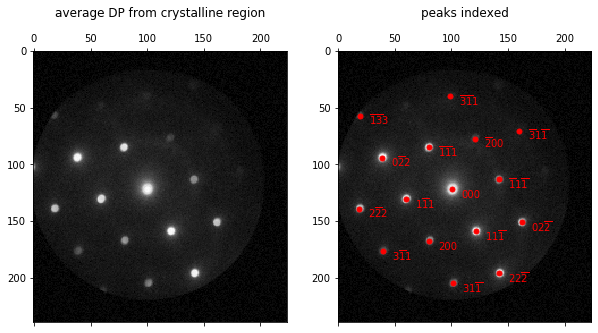

In [109]:
# Based on the angles and ratios, this is assigned as the [011] Zone Axis of Silicon 
# Now let's index those peaks 
labels = ['000', '0'+ r'$\overline{2}$'+'2', '11'+ r'$\overline{1}$', '22'+r'$\overline{2}$', '1'+ r'$\overline{1}$'+'1', r'$\overline{1}$'+r'$\overline{1}$'+'1', '02'+r'$\overline{2}$', 
         '2'+r'$\overline{2}$'+'2', r'$\overline{1}$'+'1'+r'$\overline{1}$', '200', '31'+r'$\overline{1}$', '3'+r'$\overline{1}$'+'1', r'$\overline{3}$'+r'$\overline{1}$'+'1', 
          r'$\overline{1}$'+r'$\overline{3}$'+'3',  r'$\overline{3}$'+'1'+r'$\overline{1}$', r'$\overline{2}$'+'0'+'0']
power = 0.5
fig, ax = plt.subplots(1,2, figsize= [10,5])
ax[0].matshow(avDP_crystalline**power)
ax[0].set_title('average DP from crystalline region', pad = 20)
ax[1].matshow(avDP_crystalline**power)
ax[1].set_title('peaks indexed', pad = 20)
ax[1].scatter(crystal_peaks.data['qy'], crystal_peaks.data['qx'], color = 'r', s= 25) 
for i in range(len(labels)):
    ax[1].annotate(labels[i], (crystal_peaks.data['qy'][i]+8, crystal_peaks.data['qx'][i]+8), color ='r', fontsize= 10)

plt.show()

In [110]:
# Assigned Indices Above
indices = np.array(
         [0,-2, 2, 
         1,1,-1,
         2,2,-2,
         1,-1,1,
         -1,-1,1,
         0,2,-2, 
         2,-2,2,
         -1,1,-1,
         2,0,0,
         3,1,-1,
         3,-1,1, 
         -3,-1,1,
         -1,-3,3,
         -3,1,-1,
         -2,0,0]).reshape(15,3)

# Silicon Lattice Parameter
a= 5.431020511 # Angstroms 

# Calculated Distances
d= a/np.sqrt(np.sum(indices**2, axis = 1))

# Distances of detected disks from center peak
qr = np.sqrt((crystal_peaks.data['qx'][1::]-crystal_peaks.data['qx'][0])**2+(crystal_peaks.data['qy'][1::]-crystal_peaks.data['qy'][0])**2)

# Callibrating Pixel Size 
dq = np.mean((1/(qr*d)))

In [111]:
# Saving the scale into a py4DSTEM format
coordinates = [('dq', 'float64')]
scale = PointList(coordinates = coordinates, name = 'dq')
dq = np.asarray([dq])
dq = dq.astype(float)
scale.add_point(dq)

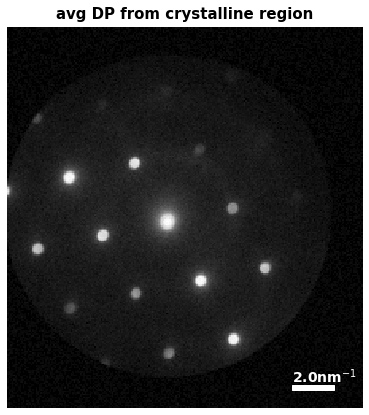

In [138]:
# Plotting the diffraction pattern with a scalebar 
scalebar_location = [dc.Q_Ny-dc.Q_Ny/5, dc.Q_Nx-dc.Q_Ny/15]
scalebar_size = [2/(10*dq),3]
scalebar_label = str(np.round(dq*10*scalebar_size[0],0)[0])+'nm'+'$^{-1}$'
scalebar_color = 'w'

fig, ax = plt.subplots(1,1, figsize= [7,7])
ax.matshow(avDP_crystalline**power)
ax.set_title('avg DP from crystalline region', pad = -10, fontweight= 'bold', fontsize = 15)
scalebar = Rectangle((scalebar_location[0],scalebar_location[1]), scalebar_size[0],scalebar_size[1], color=scalebar_color)
ax.add_patch(scalebar)
ax.text(x=scalebar_location[0], y =scalebar_location[1]-(scalebar_size[1]/2), s=scalebar_label, fontweight='bold', fontsize= 14, color = scalebar_color)
ax.axis('off')

plt.show()

## 7. Store important information 

In [113]:
data_objects = [braggpeaks, virtual_ADF_image, virtual_BF_image, avg_DP_ROI, ROI, scale]

In [114]:
savepath = "/Users/jenniferdonohue/Documents/Research/Silicon/alpha-Si-counted-bin8x_cropped_info.h5"
assert savepath != fp # Make sure we don't accidentally overwrite our data
save(data_objects, savepath)

Creating file /Users/jenniferdonohue/Documents/Research/Silicon/alpha-Si-counted-bin8x_cropped_info.h5...
Done.
